<a href="https://colab.research.google.com/github/kebora/machine-learning/blob/main/model_for_ishara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hand Gestures DL Model
The dataset used for this notebook can be found here: https://drive.google.com/drive/folders/1iKaVUYmJoZeApCvsp2SQNPzrSt_wC9KH

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# loading the dataset
datapath = "/content/drive/MyDrive/hagrid-sample-30k-384p"
ann_path = datapath + "/ann_train_val"
img_path = datapath + "/hagrid_30k"

## Data Exploration

In [ ]:
# Get a sample json annotation file
import json
import os

json_file = os.path.join(ann_path,"like.json")


with open(json_file,'r') as f:
  data = json.load(f)


print(f"Keys {data.keys()}")
print(data.pop("000484ab-5fd0-49b8-9253-23a22b71d7b1"))

Keys dict_keys(['000484ab-5fd0-49b8-9253-23a22b71d7b1', '002f1d76-250f-4322-b1c3-4dd4906780d4', '004ae8d7-e079-4665-a5cf-0d9b3fbc9398', '005762c1-ddc8-4ea3-becd-05f3ec326b03', '00b0135c-b2ed-439a-9bc1-8db448a0c451', '00bc44f3-0284-4a6a-892f-2131f68faf3d', '00bf711f-e2cc-4cb5-b0ac-573198cd6455', '00cda552-8720-4165-b2a7-1b5e539ba8b2', '00cf039d-fe5f-49cb-b158-aa437f6c568a', '00dfdf77-4b8b-4213-80b7-16f2b492fe4d', '00f91ea6-5ff4-4a61-99dd-6035c19bd7e3', '0100d24f-7881-465b-aed2-6a8d93ae2416', '01083636-1053-4abf-8b3a-f6f38b5491ce', '012d89fa-33f7-4922-932b-6971ce8a7a96', '0131e46b-a984-45d6-9e06-e750c58ad7fa', '01628eb2-125b-4a0d-958d-792d4ad61c5b', '01be7af5-6529-480e-8727-b55a5608c863', '01cab403-225e-4f97-a80c-1ff9de828beb', '01cd681c-a51b-493e-990e-d99ad96f63d0', '020cd45b-a632-4bd1-b769-c66c8806fc00', '02115e99-917a-4784-80a4-b0ae81f3f725', '0219dd8f-3c30-4afe-8397-8a53090bfb69', '023bff3c-b953-4b7e-adc8-2dd8adf26a70', '0266d308-b686-44d2-9633-3d7433b8a536', '026e78fd-899b-4bf2-8d8c

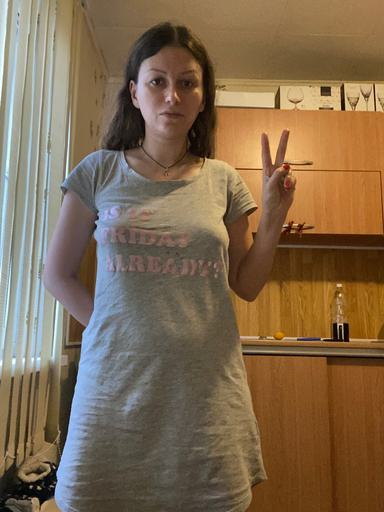

In [ ]:
# Try checking out an image:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread(img_path+"/train_val_peace/0a021e19-0499-4dd1-8bc7-991d19ab6147.jpg")
cv2_imshow(img)

## Data Preprocessing
In reference to the annotations file, I try to separate the gestures from the image using the data under the *bboxes* to create a new dataset that I use.

In [ ]:
# Define an output path to store the new dataset
output_path = "/content/drive/MyDrive/hagrid_seven"

if not os.path.exists(output_path):
    os.makedirs(output_path)

In [ ]:
print(type(data))

<class 'dict'>


The following block of code took me roughly 6 hours to finish executing, so I will just append the link to drive instead: Find it here https://drive.google.com/drive/folders/1sF50rTvRhw0iW3qVmiWWGBPxxKE9hyeO

The link leads to the cropped dataset [hagrid_seven]. That I will use from now henceforth.

In [ ]:
from PIL import Image

In [ ]:
# # Iterate through each JSON file in the annotation path:
# for json_file in os.listdir(ann_path):
#     if json_file.endswith(".json"):
#         json_file_path = os.path.join(ann_path, json_file)

#         # Open and load the JSON data
#         with open(json_file_path, 'r') as f:
#             data = json.load(f)

#         # Process each key (corresponding to image file names)
#         for image_key, entry in data.items():
#             # Use the label to determine which subfolder to look in (assuming labels match folder names)
#             label = entry['labels'][0] if entry['labels'] else "unknown"
#             gesture_folder = os.path.join(img_path, f"train_val_{label}")

#             # Construct the image path
#             img_file = os.path.join(gesture_folder, f"{image_key}.jpg")

#             if os.path.exists(img_file):
#                 # Open the image
#                 image = Image.open(img_file)
#                 img_width, img_height = image.size

#                 # Iterate through the bounding boxes and crop images
#                 for i, bbox in enumerate(entry['bboxes']):
#                     x, y, w, h = bbox
#                     # Convert relative bbox coordinates to absolute pixel values
#                     left = int(x * img_width)
#                     top = int(y * img_height)
#                     right = int((x + w) * img_width)
#                     bottom = int((y + h) * img_height)

#                     # Crop the image based on the bounding box
#                     cropped_image = image.crop((left, top, right, bottom))

#                     # Save the cropped image
#                     cropped_filename = f"{image_key}_{label}_{i}.jpg"
#                     cropped_image.save(os.path.join(output_path, cropped_filename))

#                     print(f"Cropped and saved: {cropped_filename}")
#             else:
#                 print(f"Image not found: {img_file}")

# print("Cropping process completed.")

Streaming output truncated to the last 5000 lines.
Image not found: /content/drive/MyDrive/hagrid-sample-30k-384p/hagrid_30k/train_val_stop/8bbffc72-a9ba-474c-bbf1-d943d857c73d.jpg
Image not found: /content/drive/MyDrive/hagrid-sample-30k-384p/hagrid_30k/train_val_stop/8bc795e0-1843-4ade-8319-db456cf597cc.jpg
Image not found: /content/drive/MyDrive/hagrid-sample-30k-384p/hagrid_30k/train_val_stop/8bcbd08a-a27c-4618-8faa-28b35f117c66.jpg
Image not found: /content/drive/MyDrive/hagrid-sample-30k-384p/hagrid_30k/train_val_stop/8bcbe9df-9dd1-4e70-9759-fc692561db78.jpg
Image not found: /content/drive/MyDrive/hagrid-sample-30k-384p/hagrid_30k/train_val_stop/8bcd2baf-962f-4798-b022-5a962d596a56.jpg
Image not found: /content/drive/MyDrive/hagrid-sample-30k-384p/hagrid_30k/train_val_stop/8bdc6ca3-8958-441e-9cba-7b98291c5b74.jpg
Image not found: /content/drive/MyDrive/hagrid-sample-30k-384p/hagrid_30k/train_val_stop/8be1a761-9714-4ffe-99aa-8eb92524bb85.jpg
Image not found: /content/drive/MyDrive

## Load Dataset
Load all the cropped images and their labels

In [ ]:
output_path

'/content/drive/MyDrive/hagrid_seven'

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Since labels have been saved into the file name, example 0a1be05a-6fc3-4d5e-b9ae-68a0e54f650a_ok_0.jpg

In [ ]:
class HandGestureDatasetFromFilenames(Dataset):
    def __init__(self, img_dir, transform=None):
        """
        Args:
            img_dir (string): Path to the directory with cropped images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.img_files = os.listdir(self.img_dir)
        self.labels_map = self._create_label_map()  # Mapping gesture labels to integer classes

    def _create_label_map(self):
        """
        Create a mapping from gesture label names to numeric values.
        """
        labels = set()
        for img_file in self.img_files:
            label = img_file.split('_')[1]  # Extract the label (e.g., "fist")
            labels.add(label)
        return {label: idx for idx, label in enumerate(sorted(labels))}

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            A tuple of (image, label) where image is a transformed image and label is its corresponding gesture.
        """
        img_file = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_file)

        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Extract label from filename
        label = img_file.split('_')[1]  # Gesture label (e.g., "three2", "palm")
        label = self.labels_map[label]  # Convert to integer class

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

In [ ]:
# Defining the image transformations as:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to smaller model
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize to ImageNet standards
])

Creating and splitting the dataset

In [ ]:
from torch.utils.data import random_split, DataLoader

In [ ]:
# Create dataset
dataset = HandGestureDatasetFromFilenames(output_path, transform=transform)

# Split the dataset (80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Visualization for assurance
To check the accuracy, we use matplotlib to visualize the images and their corresponding labels.

In [ ]:
import matplotlib.pyplot as plt

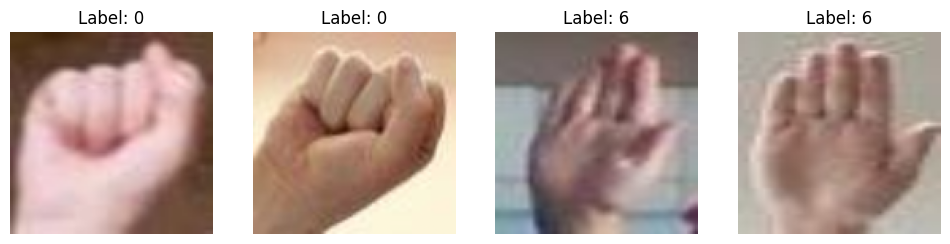

In [ ]:
# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot the first few images
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
for i in range(4):
    img = images[i].permute(1, 2, 0)  # Convert tensor to [H, W, C] for visualization
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Un-normalize the image
    img = img.numpy()

    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

plt.show()

## The CNN Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class GestureRecognitionCNN(nn.Module):
    def __init__(self, num_classes):
        super(GestureRecognitionCNN, self).__init__()

        # Fewer filters in convolution layers for a lighter model
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Adjust fully connected layers for smaller input sizes
        self.fc1 = nn.Linear(32 * 32 * 32, 256)  # (For input size 128x128 after pooling)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (batch_size, 16, 64, 64)
        x = self.pool(F.relu(self.conv2(x)))  # (batch_size, 32, 32, 32)
        x = x.view(-1, 32 * 32 * 32)  # Flatten for the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Initialize model, loss function and optimizer

In [ ]:
# Get the number of gesture classes from the dataset
num_classes = len(dataset.labels_map)

# Initialize the model
model = GestureRecognitionCNN(num_classes).to(device)

# Use cross-entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
print(f"Number of classes:{num_classes}") #Inverted classes have been merged

Number of classes:7


In [ ]:
import torch.optim as optim

In [ ]:
def train_model_with_early_stopping(model, train_loader, criterion, optimizer, num_epochs=50, patience=5):
    best_loss = float('inf')
    counter = 0
    early_stop = False

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

        # Check for improvement and early stopping
        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
            counter = 0  # Reset patience counter
        else:
            counter += 1
            print(f"Early stopping counter: {counter} out of {patience}")

        # Early stopping check
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            early_stop = True
            break

    if not early_stop:
        print(f"Training completed for {num_epochs} epochs.")

num_epochs = 200
patience = 5
train_model_with_early_stopping(model, train_loader, criterion, optimizer, num_epochs=num_epochs, patience=patience)

Epoch [1/200], Train Loss: 1.3327
Epoch [2/200], Train Loss: 0.7122
Epoch [3/200], Train Loss: 0.5573
Epoch [4/200], Train Loss: 0.4664
Epoch [5/200], Train Loss: 0.4169
Epoch [6/200], Train Loss: 0.3731
Epoch [7/200], Train Loss: 0.3248
Epoch [8/200], Train Loss: 0.3116
Epoch [9/200], Train Loss: 0.2871
Epoch [10/200], Train Loss: 0.2585
Epoch [11/200], Train Loss: 0.2359
Epoch [12/200], Train Loss: 0.2313
Epoch [13/200], Train Loss: 0.2047
Epoch [14/200], Train Loss: 0.2040
Epoch [15/200], Train Loss: 0.1827
Epoch [16/200], Train Loss: 0.1794
Epoch [17/200], Train Loss: 0.1640
Epoch [18/200], Train Loss: 0.1574
Epoch [19/200], Train Loss: 0.1535
Epoch [20/200], Train Loss: 0.1418
Epoch [21/200], Train Loss: 0.1308
Epoch [22/200], Train Loss: 0.1324
Early stopping counter: 1 out of 5
Epoch [23/200], Train Loss: 0.1247
Epoch [24/200], Train Loss: 0.1175
Epoch [25/200], Train Loss: 0.1119
Epoch [26/200], Train Loss: 0.1115
Epoch [27/200], Train Loss: 0.1114
Epoch [28/200], Train Loss: 0

In [ ]:
# # Function to train the model
# def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
#     model.train()  # Set the model to training mode

#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             # Zero the parameter gradients
#             optimizer.zero_grad()

#             # Forward pass
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             # Backward pass and optimization
#             loss.backward()
#             optimizer.step()

#             # Calculate loss and accuracy
#             running_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#         # Print epoch stats
#         epoch_loss = running_loss / len(train_loader)
#         epoch_acc = correct / total
#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# # Train the model
# train_model(model, train_loader, criterion, optimizer, num_epochs=10)

# # save the model
# torch.save(model.state_dict(), '/content/final_model.pth')

## Model Evaluation

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Loss: 1.0345, Test Accuracy: 0.8353

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       340
           1       0.82      0.86      0.84       347
           2       0.78      0.81      0.79       334
           3       0.81      0.82      0.81       357
           4       0.86      0.83      0.84       392
           5       0.83      0.79      0.81       362
           6       0.85      0.83      0.84       382

    accuracy                           0.84      2514
   macro avg       0.84      0.84      0.84      2514
weighted avg       0.84      0.84      0.84      2514



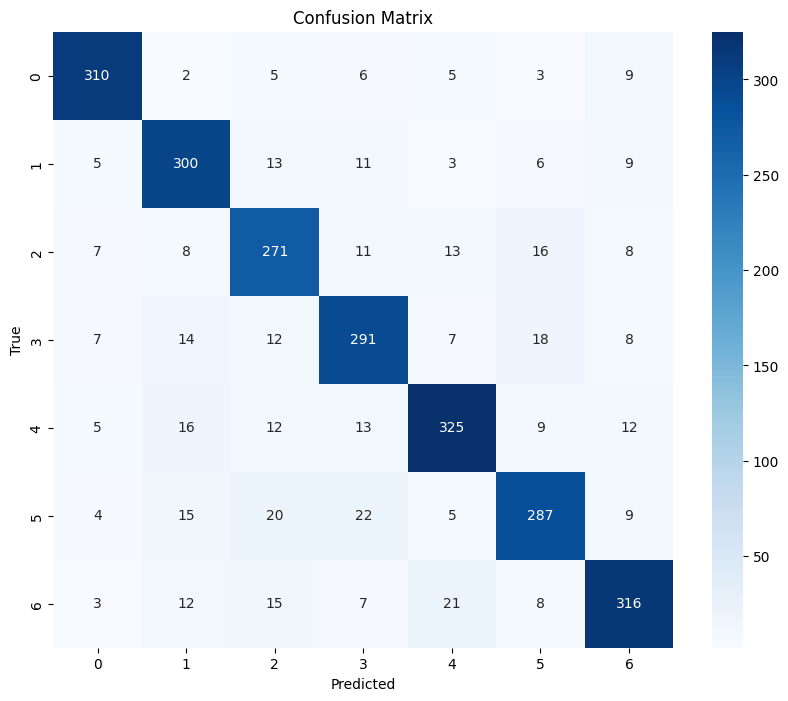

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_test_loss = running_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds))

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Example usage
evaluate_model(model, test_loader, criterion)


## Model conversion to LiteRT

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 59.4 MB/s eta 0:00:00


In [ ]:
# Load the best saved model
model.load_state_dict(torch.load('/content/best_model.pth'))
model.eval()

# Create a dummy input matching the input size used during training
dummy_input = torch.randn(1, 3, 128, 128).to(device)  # Adjust input size as needed
torch.onnx.export(
    model,
    dummy_input,
    "model.onnx",
    opset_version=11,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)
print("Model exported to ONNX format.")


<ipython-input-26-a13fb7b9fe93>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pth'))


Model exported to ONNX format.


I went through days of debugging just to convert the onnx model to tflite format. Apparently there has been many incompatibilities like: ```The latest onnx2tf implementation is based on Keras API 3 and will not work properly if you install TensorFlow v2.```
I had to make a new notebook here (With specific version changes), since I did not want to interfere with the rest of the code in this notebook that much: https://github.com/kebora/machine-learning/blob/main/Convert_onnx_to_tflite.ipynb